# Index:

- 0) Data Exploration
- 1) Feature Engineering
- 2) Data Transformation
- 3) Some of the Baselines
- 4) Backwards subset selection
- 5) Model Optimization
- 6) Final Model: Stacking
- 7) Feature Importance

In [124]:
# utils
from Utility_functs import *
import pandas as pd
import numpy as np
#import tqdm 
#import imblearn

# preprocessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import TruncatedSVD

# classifiers
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import BernoulliNB
from sklearn.naive_bayes import CategoricalNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble  import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.ensemble import VotingClassifier
from sklearn.ensemble import StackingClassifier


# evaluation
from sklearn.metrics import make_scorer
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix

# plotting
import seaborn as sns
from matplotlib import pyplot as plt
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls

pd.options.display.max_rows = 999
pd.options.display.max_columns = 999

# -------------------------------------------------------------------------------
#                                  Load Dataset

train, test, dataset = reset_dataset()
assert len(dataset[dataset.chargesTotal.isna()]) == 0
feature_importances = dict()

train shape = (4000, 18), test shape = (1986, 17)


# 0) Data Exploration

In [125]:
""" creazione lista con nomi variabili categoriche """
dtypes = train.dtypes.to_numpy()
bool_mask = np.where((dtypes != 'float64') & (dtypes != 'int64'), True, False)

cat_cols = list(train.iloc[:,bool_mask].columns)
cat_cols += ["senior"]

<AxesSubplot:title={'center':'Pearson Correlation of Features'}>

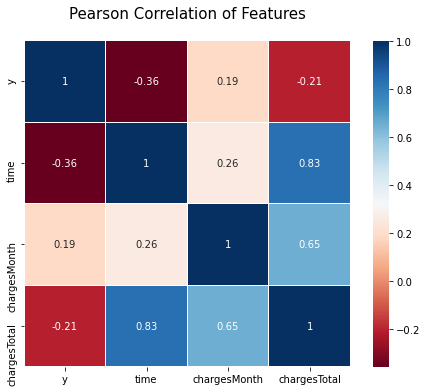

In [126]:
colormap = plt.cm.RdBu
plt.figure(figsize=(8,6))
plt.title('Pearson Correlation of Features', y=1.05, size=15)
sns.heatmap(train.drop(cat_cols,axis=1).astype(float).corr(),linewidths=0.1,vmax=1.0, 
            square=True, cmap=colormap, linecolor='white', annot=True)

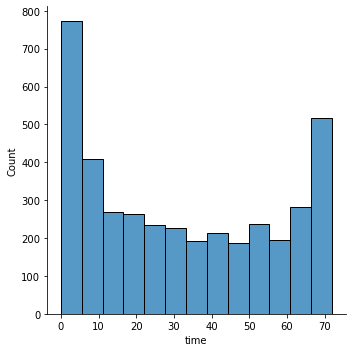

In [127]:
# time èa la più correlata alla y
sns.displot(train["time"])

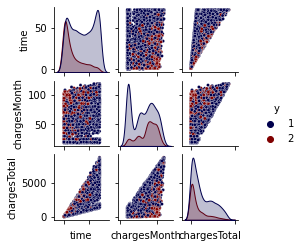

In [128]:
g = sns.pairplot(train.drop(cat_cols,axis=1), hue='y', palette = 'seismic',height=1.2,diag_kind = 'kde',diag_kws=dict(shade=True),plot_kws=dict(s=10) )
g.set(xticklabels=[])

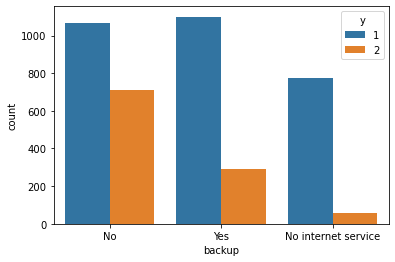

In [129]:
ax = sns.countplot(x='backup', data=train, hue="y")

# 1) Feature Engineering


**aggiungo features**


In [130]:
train, test, dset = reset_dataset()
#dset = train.copy(deep=True)
dset_enh = dset.copy(deep=True) #sub w train to see correlations


# quanto paga in più rispetto a quanto pagava prima (in media)
dset_enh["avg_surprise"] = (dset.chargesMonth * dset.time) - (dset.chargesTotal)

# incremento % (considerando anche il segno) della spesa mensile
# se time==0, metto una spesa media molto bassa, così da far uscire 0 come risultato finale
# avg_surprise2 avrà valore 0 se la spesa nuova è simile a quella media, >0 se maggiore della media, 
# > 1 se più del doppio della spesa media
time = dset.time.to_numpy()
time[time == 0] = 0.00001
# prima sottraevo la spesa mensile a charges total, ma in raeltà è già non inclusa, infatti se time==0, spesatotale=0
# nota, metto un segno meno ad avg_expenditure poiché indica una spesa,che mi piace pensare come importo negativo
avg_expenditure = ((dset.chargesTotal)/ time )
#dset_enh["avg_surprise2"] = ( (avg_expenditure - dset.chargesMonth)/abs(avg_expenditure)) 

# spesa media
dset_enh["avg_expenditure"] = avg_expenditure

dset_enh.fillna(0, axis=1, inplace=True)

dset_enh.iloc[:4000,:].corr()

train shape = (4000, 18), test shape = (1986, 17)


,y,senior,time,chargesMonth,chargesTotal,avg_surprise,avg_expenditure
y,1.000000,0.152268,-0.358064,0.186510,-0.207830,0.011984,0.186984
senior,0.152268,1.000000,0.008817,0.217438,0.094516,0.005778,0.215827
time,-0.358064,0.008817,1.000000,0.262295,0.833776,-0.020818,0.263536
chargesMonth,0.186510,0.217438,0.262295,1.000000,0.653476,-0.009802,0.994905
chargesTotal,-0.207830,0.094516,0.833776,0.653476,1.000000,-0.054348,0.653650
avg_surprise,0.011984,0.005778,-0.020818,-0.009802,-0.054348,1.000000,-0.068010
avg_expenditure,0.186984,0.215827,0.263536,0.994905,0.653650,-0.068010,1.000000


**creazione dummies**

In [131]:
dset_enh_dum = pd.get_dummies(dset_enh, columns = cat_cols, drop_first=True, prefix= ["col" + str(i) for i in range(len(cat_cols))])
dset_enh_dum.head()

,y,time,chargesMonth,chargesTotal,avg_surprise,avg_expenditure,col0_Male,col1_Yes,col2_Yes,col3_No phone service,col3_Yes,col4_Fiber optic,col4_No,col5_No internet service,col5_Yes,col6_No internet service,col6_Yes,col7_No internet service,col7_Yes,col8_No internet service,col8_Yes,col9_No internet service,col9_Yes,col10_No internet service,col10_Yes,col11_Yes,col12_Credit card (automatic),col12_Electronic check,col12_Mailed check,col13_1
0,1.0,49,66.15,3199.00,42.35,65.285714,1,0,1,0,1,0,0,0,0,0,0,0,0,0,1,0,1,0,0,1,0,0,0,0
1,1.0,6,50.95,307.60,-1.90,51.266667,0,0,0,1,0,0,0,0,1,0,1,0,0,0,1,0,0,0,1,0,1,0,0,0
2,2.0,1,19.75,19.75,0.00,19.750000,1,0,1,0,0,0,1,1,0,1,0,1,0,1,0,1,0,1,0,0,0,0,1,0
3,1.0,19,45.00,865.85,-10.85,45.571053,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
4,1.0,9,19.50,178.85,-3.35,19.872222,0,0,1,0,0,0,1,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,0


**aggiungo interaction terms ad hoc**

In [132]:
""" creo interaction ad hoc """

interactions= []

# col4_Fiber_optic
#int_col4 = dset_enh_dum.drop("y",axis=1).mul(dset_enh_dum["col4_Fiber optic"], axis=0).add_prefix('col4*')

# multiple itneractions
#int_mult = dset_enh_dum["time"] * dset_enh_dum["col5_No"] * dset_enh_dum["col8_No"] * dset_enh_dum["col12_Electronic check"]
#interactions.append(int_mult)

# female + senior
#old_ladies = dset_enh_dum["senior"] * dset_enh_dum["col0_Female"] * dset_enh_dum["time"]
#interactions.append(old_ladies)

# time^2
time_2 = dset_enh_dum["time"] **2
interactions.append(time_2)

# low surprise (automatic billing)
anti_surpr = dset_enh_dum["col12_Credit card (automatic)"] * dset_enh_dum["avg_surprise"]
interactions.append(anti_surpr)

# huge backups (backup + time)
bkup = dset_enh_dum["col9_Yes"] * dset_enh_dum["time"]
interactions.append(bkup)

# no inentives (no "backup","protection","support")
no_services = dset_enh_dum["col9_Yes"] * dset_enh_dum["col10_Yes"] * dset_enh_dum["col11_Yes"]
interactions.append(no_services)

# high surprise (automatic billing)
#high_surp = dset_enh_dum["col12_Mailed check"] * dset_enh_dum["avg_surprise"]
#interactions.append(high_surp)


relevant_surprise = dset_enh_dum["avg_surprise"] * dset_enh_dum["chargesTotal"]
interactions.append(relevant_surprise)


# -----------------------
# join
df_prova = pd.concat([dset_enh_dum] + interactions, axis=1)

_dset = df_prova.copy(deep=True)
train_enh_prova, test_enh_prova = split_dset(_dset, split_val=4000)
train_enh_prova.shape, test_enh_prova.shape

((4000, 35), (1986, 34))

**droppo features**

droppo alcune features rivelatesi poco interessanti (gender, married, phone) e alcune dummies identiche

In [133]:
duplicated_dummies = ["col"+str(i)+"_No internet service"for i in[5,6,7,8,9]]
df_enh_pre_drop = dset_enh_dum.drop(columns=duplicated_dummies, axis=1).copy(deep=True)

train_enh_org = dset_enh_dum.iloc[:4000,:].copy(deep=True)
uninteresting_cols = ["col0_Male", "col1_Yes", "col2_Yes"] + duplicated_dummies
#uninteresting_cols = [col for col in dset_enh_dum.columns  for i in cols if col.startswith(str(i)+"_")]   

dset_enh_dum = dset_enh_dum.drop(columns=uninteresting_cols, axis=1)
df_prova     = df_prova.drop(columns=uninteresting_cols, axis=1)

**creo un df in cui aggiungo interaction terms in massa**

In [134]:
""" creo dset_poly """
# non facciamo il quadrato o le interaction della y 
df = dset_enh_dum.copy(deep=True)
df = df.reset_index(drop=True)

cols = ["col" + str(i) for i in[1,4,6,7,8,11,12]]
interesting_cols = [col for col in dset_enh_dum.columns  for i in cols if col.startswith(str(i))]     
non_interesting = [i for i in dset_enh_dum.columns if i not in interesting_cols]
to_drop = ["y"] + non_interesting


# interaction di ognuno verso ogni altro + le features iniziali,

poly = PolynomialFeatures(2, interaction_only = True, include_bias = False)
poly.fit(df.drop(to_drop, axis=1))

dset_poly  = pd.DataFrame(poly.transform(df.drop(to_drop, axis=1)))
print("shape del train_poly senza aggiungere le var escluse", dset_poly.shape)

# aggiungiamo le var escluse
to_drop.remove("y")
dset_poly = pd.concat([df.drop(interesting_cols, axis=1), dset_poly], axis=1)
#dset_poly["y"] = df["y"]

dset_poly.head(3)

shape del train_poly senza aggiungere le var escluse (5986, 78)


,y,time,chargesMonth,chargesTotal,avg_surprise,avg_expenditure,col3_No phone service,col3_Yes,col5_Yes,col9_Yes,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77
0,1.0,49,66.15,3199.00,42.35,65.285714,0,1,0,1,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1.0,6,50.95,307.60,-1.90,51.266667,1,0,1,0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2.0,1,19.75,19.75,0.00,19.750000,0,0,0,0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# 2) Data Trasformation 

[sklearn_preprocessing](https://scikit-learn.org/stable/modules/preprocessing.html)

### splitting test and train
(necessario per fittare i metodi di data transformation solo sul train ed applicarli anche al test)

In [135]:
_dset = dset_enh_dum.copy(deep=True)
train_enh_dum, test_enh_dum = split_dset(_dset, split_val=4000)
train_enh_dum.shape, test_enh_dum.shape

_dset = df_enh_pre_drop.copy(deep=True)
train_enh_pre_drop, test_enh_pre_drop = split_dset(_dset, split_val=4000)
train_enh_pre_drop.shape, test_enh_pre_drop.shape

_dset = dset_poly.copy(deep=True)
train_enh_poly, test_enh_poly = split_dset(_dset, split_val=4000)
train_enh_poly.shape, test_enh_poly.shape

# -----------------------------------

train_dfs = []
train_dfs.extend(["train_enh_dum", "train_enh_poly", "train_enh_prova"])

### [Normalizzazione](https://scikit-learn.org/stable/modules/preprocessing.html)

In [136]:
""" Uso lo Standard Scaler di Sklearn """

def standardize_data(train_df, test_df, cat_cols=None):
    assert train_df.drop("y", axis=1).shape[1] == test_df.shape[1], "unequal shapes"
    
    # non vogliamo scalare la y quindi la droppiamo da qui
    to_drop = ["y"]
#    if cat_cols:
#        to_drop += cat_cols     
    
    scaler = StandardScaler()
    scaler.fit(train_df.drop("y", axis=1))

    stded_train = scaler.transform(train_df.drop("y", axis=1))
    stded_test  = scaler.transform(test_df)
    
    names = [i for i in train_df.columns if i != "y"]
    train_stded = pd.DataFrame(stded_train, columns= names)
    train_stded["y"] = train_df["y"]
    test_stded = pd.DataFrame(stded_test, columns= names)

    return train_stded, test_stded

train_enh_stded, test_enh_stded =  standardize_data(train_enh_dum, test_enh_dum)
train_dfs.append("train_enh_stded")

train_enh_pre_stded, test_enh_pre_stded =  standardize_data(train_enh_pre_drop, test_enh_pre_drop)
train_dfs.append("train_enh_pre_stded")

train_prova_stded, test_prova_stded =  standardize_data(train_enh_prova, test_enh_prova)
train_dfs.append("train_prova_stded")

train_poly_stded, test_poly_stded = standardize_data(train_enh_poly, test_enh_poly)
train_dfs.append("train_poly_stded")

# 3) Some of the Baselines 

**[Bernoulli Naive Bayes](https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.BernoulliNB.html#sklearn.naive_bayes.BernoulliNB)**

In [81]:
df = train_enh_dum 
X, y = create_X_y(df)

prior_l = 0.4
priors = [prior_l, 1-prior_l]

B_NB = BernoulliNB(alpha=1,
                   class_prior=priors) #priors=priors
cv_result = compute_cv(B_NB, X, y, 10, scorer=loss_function)

mean =  -210.9 std =  19.429101883514843


**[QDA](https://scikit-learn.org/stable/modules/generated/sklearn.discriminant_analysis.QuadraticDiscriminantAnalysis.html)**

In [82]:
df = train_enh_dum 
X, y = create_X_y(df)

prior_l = 0.35 
priors = [prior_l, 1-prior_l]

QDA = QuadraticDiscriminantAnalysis(tol=-1, priors=priors) #priors=priors
cv_result = compute_cv(QDA, X, y, 10, scorer=loss_function)

mean =  -320.1 std =  81.08076220658018


**[SVM](https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html)**


In [83]:
df = train_poly_stded #.drop("senior",axis=1) 
X, y = create_X_y(df)

class_weight = {1:1, 2:5}
_SVC = SVC(class_weight=class_weight,
           kernel = "rbf",
           C=1.5,
           probability=False,         # settalo a true prima di fare fit
           random_state=0,
           cache_size=600) 

cv_result = compute_cv(_SVC, X, y, 10, scorer=loss_function)

mean =  -207.4 std =  26.012304780622575


**[KNN Classifier](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html)** (non sembra avere class weights, occorre settare una threshold, crea un custom k_folds).



In [84]:
k= 10
df = train_enh_stded
thr = 0.8

KNN = KNeighborsClassifier(n_neighbors=50, weights= "distance", p=2, n_jobs=-1)

cv_scores = custom_k_folds(KNN, df, thr=thr)

mean =  189.1 std = 27.020177645604036


**[MLP Classifier](https://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPClassifier.html)**

In [85]:
""" from sklearn.neural_network import MLPClassifier

df = train_enh_stded 
X, y = create_X_y(df)

MLP = MLPClassifier(alpha = 0.001,        #l2 regularization
                    #learning_rate="invscaling",
                    #activation="relu",
                    learning_rate_init=0.001,
                    #early_stopping=True,
                    random_state=1,
                    max_iter=900)

cv_result = compute_cv(MLP, X, y, 10, scorer=loss_function)
"""

C:\Users\Eugen\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations (600) reached and the optimization hasn't converged yet.

C:\Users\Eugen\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations (600) reached and the optimization hasn't converged yet.

C:\Users\Eugen\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations (600) reached and the optimization hasn't converged yet.

C:\Users\Eugen\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations (600) reached and the optimization hasn't converged yet.



mean =  -285.1 std =  21.454370184183922


# 4) Backwards Feature Selection


In [66]:
""" #Backwards subset selection with LR 

import itertools

df = train_enh_pre_drop #[[col for col in train_enh_stded if col!="avg_expenditure"]] 
X = df.drop("y",axis=1)
y = df.y.to_numpy()

weights = {1:1, 2:4.25}
LR = LogisticRegression(max_iter=2000,
                        #C = 0.7,
                        random_state=0,
                        solver = 'liblinear',  # liblinear good for small datasets
                        class_weight= weights) 

lista_risultati = []
curr_cols = [col for col in X.columns]
#Looping 
for k in range(len(X.columns), 3, -1):
    
    eva_cols = []
    train_err = np.zeros(k)
    #Looping over all possible combinations: from 11 choose k
    for i, col in enumerate(curr_cols):
        curr_X = X.drop(col,axis=1)
        LR.fit(curr_X ,y)
        train_err[i] = custom_scorer(y, LR.predict(curr_X))
        eva_cols.append(col)

    col_to_remove = curr_cols[np.argmin(train_err)]
    curr_cols.remove(col_to_remove)
    lista_risultati.append([k, curr_cols.copy(), col_to_remove])

#Store in DataFrame
#colonne_df = ["num_features", 'cv_mean',"cv_std", "features" ]
#risultati = pd.DataFrame(lista_risultati, columns = colonne_df)
colonne_df = ["num_features", "features", "removed_col" ]
risultati = pd.DataFrame(lista_risultati, columns = colonne_df)
#risultati.to_csv("bss_lr.csv")
risultati #.sort_values("train_err").groupby("num_features", as_index=False).first()
"""

,num_features,features,removed_col
0,29,"[time, chargesMonth, chargesTotal, avg_surpris...",col5_Yes
1,28,"[time, chargesMonth, chargesTotal, avg_surpris...",col6_Yes
2,27,"[time, chargesMonth, chargesTotal, avg_surpris...",col8_Yes
3,26,"[time, chargesMonth, chargesTotal, avg_surpris...",col0_Male
4,25,"[time, chargesMonth, chargesTotal, avg_surpris...",col1_Yes
5,24,"[time, chargesMonth, chargesTotal, avg_surpris...",col4_Fiber optic
6,23,"[time, chargesMonth, chargesTotal, avg_surpris...",col12_Mailed check
7,22,"[time, chargesMonth, chargesTotal, avg_expendi...",avg_surprise
8,21,"[time, chargesMonth, chargesTotal, avg_expendi...",col13_1
9,20,"[time, chargesMonth, chargesTotal, col2_Yes, c...",avg_expenditure


In [ ]:
"""# evaluating p models with RF 

class_weights = {1:1, 2:5}
RF = RandomForestClassifier(n_estimators= 1000,
                            n_jobs=-1,
                            random_state=0,
                            class_weight= class_weights,
                            #min_samples_leaf = 50,
                            #min_samples_split =3,
                            max_leaf_nodes = 45,
                            criterion='entropy',
                            max_features="log2")

scores = []
for cols in risultati.features.to_list():
    X = df[cols]
    y = df.y.to_numpy()
    cv_result = compute_cv(RF, X, y, 10, scorer=loss_function)
    scores.append([len(cols), cols, cv_result.mean(), cv_result.std()])
    
colonne_df = ["num_features", "features", "mean test_error", "test_error_std" ]
df_scores_RF = pd.DataFrame(scores, columns = colonne_df)
risultati.to_csv("df_scores_RF.csv")
df_scores_RF
""" 

In [67]:
"""  #evaluating p models with LR 

weights = {1:1, 2:4.25}
LR = LogisticRegression(max_iter=2000,
                        #C = 1.2,
                        random_state=0,
                        solver = 'liblinear',  # liblinear good for small datasets
                        class_weight= weights) 

scores = []
for cols in risultati.features.to_list():
    X = df[cols]
    y = df.y.to_numpy()
    cv_result = compute_cv(LR, X, y, 10, scorer=loss_function)
    scores.append([len(cols), cols, cv_result.mean(), cv_result.std()])
    
colonne_df = ["num_features", "features", "mean test_error", "test_error_std" ]
df_scores_LR = pd.DataFrame(scores, columns = colonne_df)
risultati.to_csv("df_scores_LR.csv")
df_scores_LR
"""

mean =  -175.2 std =  11.989995829857492
mean =  -175.4 std =  10.229369482035539
mean =  -174.5 std =  11.569356075426152
mean =  -175.2 std =  10.833282051160674
mean =  -175.5 std =  10.809717850156867
mean =  -183.5 std =  14.609928131240071
mean =  -181.8 std =  13.78259772321604
mean =  -181.1 std =  11.80211845390479
mean =  -186.4 std =  12.09297316626478
mean =  -186.0 std =  13.62350909274112
mean =  -186.8 std =  13.302631318652711
mean =  -186.7 std =  14.574292435655325
mean =  -187.5 std =  14.284607099952032
mean =  -187.4 std =  13.828955130450025
mean =  -187.7 std =  14.028898745090435
mean =  -186.2 std =  10.428806259586953
mean =  -186.0 std =  10.658330075579382
mean =  -187.8 std =  11.914696806885184
mean =  -187.7 std =  11.832582135780845
mean =  -187.7 std =  11.832582135780845
mean =  -186.4 std =  13.101144988129855
mean =  -186.5 std =  13.45548215412588
mean =  -190.3 std =  21.269931828757702
mean =  -190.4 std =  21.518364250100422
mean =  -187.6 std = 

,num_features,features,mean test_error,test_error_std
0,28,"[time, chargesMonth, chargesTotal, avg_surpris...",-175.2,11.989996
1,27,"[time, chargesMonth, chargesTotal, avg_surpris...",-175.4,10.229369
2,26,"[time, chargesMonth, chargesTotal, avg_surpris...",-174.5,11.569356
3,25,"[time, chargesMonth, chargesTotal, avg_surpris...",-175.2,10.833282
4,24,"[time, chargesMonth, chargesTotal, avg_surpris...",-175.5,10.809718
5,23,"[time, chargesMonth, chargesTotal, avg_surpris...",-183.5,14.609928
6,22,"[time, chargesMonth, chargesTotal, avg_surpris...",-181.8,13.782598
7,21,"[time, chargesMonth, chargesTotal, avg_expendi...",-181.1,11.802118
8,20,"[time, chargesMonth, chargesTotal, avg_expendi...",-186.4,12.092973
9,19,"[time, chargesMonth, chargesTotal, col2_Yes, c...",-186.0,13.623509


# 5) Models and Hyperparameters Optimization

**note:** \
confusion matrix scores are: \
true_positives, false negatives \
false_positives, true_negatives

**[Logistic Regression](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html)**



In [62]:
"""  
#grid search
df = train_enh_stded
X, y = create_X_y(df)

params={"C":np.arange(0.7,1.5,0.05),
        #"class_weight":[{1:1, 2:i} for i in np.arange(4,6,0.25)]
        }

grid = GridSearchCV(LogisticRegression(max_iter=2000,
                        #C=1.2,
                        random_state=0,
                        solver = 'liblinear',  # liblinear good for small datasets
                        class_weight={1:1,2:4.25}
                                      ),                     
                   param_grid = params, 
                   scoring = loss_function,
                   cv=10)
                   #verbose = 1)

grid.fit(X, y)

res = pd.DataFrame(grid.cv_results_)
print(grid.best_estimator_, grid.best_score_)
res
"""

LogisticRegression(C=1.3500000000000005, class_weight={1: 1, 2: 4.25},
                   max_iter=2000, random_state=0, solver='liblinear') -172.7


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,split5_test_score,split6_test_score,split7_test_score,split8_test_score,split9_test_score,mean_test_score,std_test_score,rank_test_score
0,0.019289,0.001951,0.000300,0.000458,0.7,{'C': 0.7},-223.0,-127.0,-183.0,-175.0,-171.0,-164.0,-185.0,-174.0,-173.0,-158.0,-173.3,22.746648,9
1,0.019389,0.001685,0.000300,0.000458,0.75,{'C': 0.75},-223.0,-127.0,-183.0,-175.0,-171.0,-164.0,-185.0,-174.0,-173.0,-158.0,-173.3,22.746648,9
2,0.018789,0.001599,0.000399,0.000489,0.8,{'C': 0.8},-223.0,-127.0,-183.0,-175.0,-172.0,-164.0,-185.0,-174.0,-173.0,-158.0,-173.4,22.738514,12
3,0.019590,0.002198,0.000100,0.000300,0.85,{'C': 0.8500000000000001},-223.0,-127.0,-183.0,-175.0,-172.0,-164.0,-185.0,-174.0,-173.0,-158.0,-173.4,22.738514,12
4,0.018489,0.001746,0.000100,0.000300,0.9,{'C': 0.9000000000000001},-223.0,-127.0,-183.0,-175.0,-172.0,-164.0,-185.0,-174.0,-173.0,-158.0,-173.4,22.738514,12
5,0.019288,0.001997,0.000200,0.000400,0.95,{'C': 0.9500000000000002},-223.0,-127.0,-183.0,-175.0,-172.0,-164.0,-185.0,-173.0,-173.0,-158.0,-173.3,22.737854,9
6,0.019990,0.002000,0.000600,0.000490,1.0,{'C': 1.0000000000000002},-223.0,-127.0,-183.0,-175.0,-172.0,-164.0,-186.0,-173.0,-173.0,-158.0,-173.4,22.791226,12
7,0.018888,0.001811,0.000000,0.000000,1.05,{'C': 1.0500000000000003},-223.0,-127.0,-183.0,-175.0,-172.0,-164.0,-186.0,-173.0,-173.0,-158.0,-173.4,22.791226,12
8,0.019490,0.001687,0.000000,0.000000,1.1,{'C': 1.1000000000000003},-223.0,-122.0,-183.0,-175.0,-172.0,-164.0,-186.0,-173.0,-173.0,-158.0,-172.9,23.834639,8
9,0.019191,0.001248,0.000297,0.000454,1.15,{'C': 1.1500000000000004},-222.0,-122.0,-183.0,-175.0,-172.0,-164.0,-186.0,-173.0,-173.0,-158.0,-172.8,23.625410,4


mean =  -173.2 std =  22.346364357541475


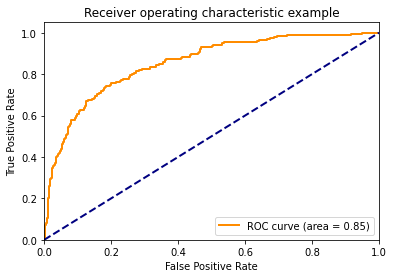

In [86]:
df = train_enh_dum #[[i for i in train_enh_dum.columns if i!="avg_surprise2"]]
df_test = test_enh_dum
X, y = create_X_y(df)

weights = {1:1, 2:4.25}
LR = LogisticRegression(max_iter=2000,
                        C=1.2000000000000004,
                        random_state=0,
                        solver = 'liblinear',  # liblinear good for small datasets
                        class_weight= weights) 

cv_result = compute_cv(LR, X, y, 10, loss_function)

LR.fit(X, y)
fpr, tpr, roc_auc = find_ROC_Score(df, LR)
plot_ROC(fpr, tpr, roc_auc)

y_pred = LR.predict(df_test)
get_txt(y_pred, filename = "LR_Predictions.txt")

---
**[LDA](https://scikit-learn.org/stable/modules/generated/sklearn.discriminant_analysis.LinearDiscriminantAnalysis.html)**

auto shrinakge gives similar results to a shrinkage of the order of 0.01

In [418]:
""" 
# grid search
df = train_enh_stded
X, y = create_X_y(df)

params={"shrinkage":np.arange(0.001, 0.1, 0.001)
        }

grid = GridSearchCV(LinearDiscriminantAnalysis(solver = "lsqr",
                                 #shrinkage="auto",
                                 priors=priors),                     
                   param_grid = params, 
                   scoring = loss_function,
                   cv=10)
                   #verbose = 1)

grid.fit(X, y)

res = pd.DataFrame(grid.cv_results_)
grid.best_estimator_, grid.best_score_
"""

(LinearDiscriminantAnalysis(priors=[0.35, 0.65], shrinkage=0.011, solver='lsqr'),
 -175.2)

mean =  -174.7 std =  21.4151815308673


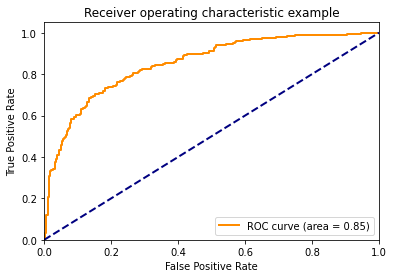

In [87]:
""" fit """

df = train_enh_stded
df_test = test_enh_stded
X, y = create_X_y(df)

prior_l = 0.35 
priors = [prior_l, 1-prior_l]

LDA = LinearDiscriminantAnalysis(solver = "eigen",
                                 shrinkage="auto",
                                 priors=priors) #priors=priors

cv_result = compute_cv(LDA, X, y, 10, scorer=loss_function)

LDA.fit(X,y)

fpr, tpr, roc_auc = find_ROC_Score(df, LDA)
plot_ROC(fpr, tpr, roc_auc)

y_pred = LDA.predict(df_test)
get_txt(y_pred, filename = "LDA_Predictions.txt")

In [28]:
""" confusion matrix """
df = train_enh_dum

prior_l = 0.35
priors = [prior_l, 1-prior_l]


LDA = LinearDiscriminantAnalysis(solver = "eigen",
                                shrinkage="auto",
                                priors=priors
                                )


cv_scores, y_tr_y_pr, y_prob = custom_k_folds(LDA, df)

y_tr_y_pr

conf_matrices = np.zeros((2,2))
for i in range(len(y_tr_y_pr)):
    conf_matrix = confusion_matrix(y_tr_y_pr[i][0], y_tr_y_pr[i][1])
    conf_matrices += conf_matrix     
               
conf_matrices/len(y_tr_y_pr)

mean =  175.8 std = 21.334479135896427


array([[182.2, 111.8],
       [ 12.8,  93.2]])

**[Gaussian Naive Bayes](https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.GaussianNB.html)**

predice benissimo la seconda classe, paradossalmente buiaogna metteren una prior in verso opposto.
magari posso sfruttarlo per 'fidarmi' delle sue predizioni su una classe.
con p=0.1 predici bene 

In [ ]:
df = train_enh_dum 
X, y = create_X_y(df)

prior_l = 0.9
priors = [prior_l, 1-prior_l]
G_NB = GaussianNB(priors=priors) #priors=priors
cv_result = compute_cv(G_NB, X, y, 10, scorer=loss_function)

G_NB.fit(X,y)
preds = G_NB.predict(test_enh_dum)

fpr, tpr, roc_auc = find_ROC_Score(train_enh_dum, G_NB)
plot_ROC(fpr, tpr, roc_auc)

In [ ]:
""" confusion matrix prior alta """
df = train_enh_dum 
X, y = create_X_y(df)

prior_l = 0.9
priors = [prior_l, 1-prior_l]
G_NB = GaussianNB(priors=priors) #priors=priors
cv_result = compute_cv(G_NB, X, y, 10, scorer=loss_function, silence=True)


cv_scores, y_tr_y_pr, _ = custom_k_folds(G_NB, df)

mean_conf_matrix(y_tr_y_pr)

In [ ]:
""" confusion matrix prior bassa """
df = train_enh_dum 
X, y = create_X_y(df)

prior_l = 0.1
priors = [prior_l, 1-prior_l]
G_NB = GaussianNB(priors=priors) #priors=priors
cv_result = compute_cv(G_NB, X, y, 10, scorer=loss_function, silence=True)


cv_scores, y_tr_y_pr, _ = custom_k_folds(G_NB, df)

mean_conf_matrix(y_tr_y_pr)

**[Random Forest Classifier](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html)**


mean =  -176.8 std =  18.475930287809597


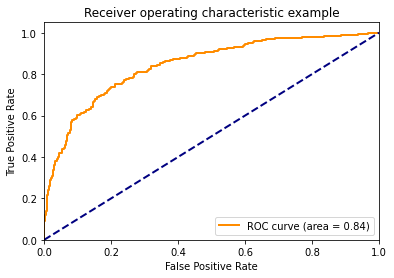

In [199]:
""" #fitto il best model (e faccio feature importances )
df = train_enh_dum
df_test = test_enh_dum
X, y = create_X_y(df)

class_weights = {1:1, 2:5}
RF = RandomForestClassifier(n_estimators= 1000,
                            #n_jobs=-1,
                            random_state=10,
                            class_weight= class_weights,
                            #min_samples_leaf = 50,
                            #min_samples_split =3,
                            max_leaf_nodes = 45,
                            criterion='entropy',
                            max_features= 0.16) #'log2'

cv_result = compute_cv(RF, X, y, 10, loss_function)
#cv_result, _, _  = k_folds_upsampling(RF, df, 7, ratio=0, k_neighbors=800)

RF.fit(X,y)
fpr, tpr, roc_auc = find_ROC_Score(train_enh_dum, RF)
plot_ROC(fpr, tpr, roc_auc)

#y_pred = RF.predict(df_test)
#get_txt(y_pred, filename = "RF_Predictions.txt")

feature_importances["rf"] = RF.fit(X, y).feature_importances_
"""

**[AdaBoost Classifier](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.AdaBoostClassifier.html)** (DecisionTreeBoosting)

se d=2 -> 28 estimators con learning rate = 0.35 o al max 0.4

se d=1 -> 174 estimators con 0.4 learning rate

In [145]:
"""  # grid search
df = train_enh_stded 
X, y = create_X_y(df)

#class_weight = {1:1, 2:4}
params={#"n_estimators":  np.arange(140,190,3),
        "n_estimators":  [1500,2000],
        "learning_rate": np.arange(0.09,0.12,0.01),
        #"base_estimator":[DecisionTreeClassifier(max_depth=2, class_weight=i) for i in [{1:1, 2:4},{1:1, 2:5},{1:1, 2:6}]]
        }

grid = GridSearchCV(AdaBoostClassifier(DecisionTreeClassifier(max_depth=1, 
                                                              #class_weight=class_weight
                                                              ),                     
                                       random_state=0,
                                       #n_estimators=174,
                                       #learning_rate = 0.4,
                                          ),
                   param_grid = params, 
                   scoring = loss_function,
                   cv=10)
                   #verbose = 1)

grid.fit(X, y)

res = pd.DataFrame(grid.cv_results_)
grid.best_estimator_, grid.best_score_
"""

(AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=1),
                    learning_rate=0.09999999999999999, n_estimators=1500,
                    random_state=0),
 -278.3)

mean =  -175.4 std =  25.519404381764087


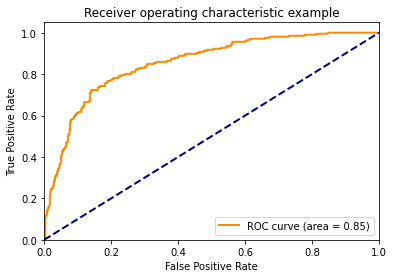

In [200]:
""" #qui metto max_depth=1 
df = train_enh_stded 

class_weight = {1:1, 2:6}
Ada = AdaBoostClassifier(DecisionTreeClassifier(max_depth=1, class_weight=class_weight),
                         n_estimators=174,
                         learning_rate = 0.4,     #default = 1
                         random_state=0)

cv_result = compute_cv(Ada, X, y, 10, scorer=loss_function)

Ada.fit(X,y)
fpr, tpr, roc_auc = find_ROC_Score(train_enh_dum, Ada)
plot_ROC(fpr, tpr, roc_auc)

y_pred = Ada.predict(df_test)
get_txt(y_pred, filename = "ADA_d1_Predictions.txt")

feature_importances["ada_d1"] = Ada.fit(X, y).feature_importances_
"""

mean =  -179.3 std =  18.171681265089372


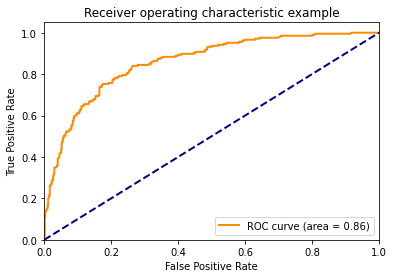

In [201]:
""" #qui metto max_depth=2 (bilanciando con meno estimators e learning rate minore) 
df = train_enh_stded 
X, y = create_X_y(df)

class_weight = {1:1, 2:4}
Ada = AdaBoostClassifier(DecisionTreeClassifier(max_depth=2, class_weight=class_weight),
                         n_estimators=28,
                         learning_rate = 0.3,     #default = 1
                         random_state=0)

cv_result = compute_cv(Ada, X, y, 10, scorer=loss_function)

Ada.fit(X,y)
fpr, tpr, roc_auc = find_ROC_Score(train_enh_dum, Ada)
plot_ROC(fpr, tpr, roc_auc)

feature_importances["ada_d2"] = Ada.fit(X, y).feature_importances_
"""

# 6) Final Model: Ensemble

### [Model Stacking](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.StackingClassifier.html )

mean =  -171.6 std =  17.86728854639114  \
usando 5.2 final class wwights, e initial class wewights solo a boosting con d=1 e random forest  

In [167]:
# data on which to fit

df_train = train_enh_stded #train_enh_dum - train_enh_stded
df_test  = test_enh_stded

X, y = create_X_y(df_train)

# adjusting labels

y=y-1
class_1 = 0
class_2 = class_1 + 1

# models' parameters

final_lr_weights  = {class_1:1, class_2:5.2}
#final_lr_weights  = {class_1:1, class_2:4.25}
lr_weights        = {class_1:1, class_2:4.25}
ada1_class_weight = {class_1:1, class_2:6}
ada2_class_weight = {class_1:1, class_2:4}
RF_class_weights  = {class_1:1, class_2:5}

prior_l = 0.3 
final_lda_priors = [prior_l, 1-prior_l]
prior_l = 0.35 
lda_priors = [prior_l, 1-prior_l]
prior_l = 0.9
gnb_priors = [prior_l, 1-prior_l]

In [168]:
# classifiers to stack

clf_1 = LogisticRegression(max_iter=2000,
                            C=1.20,
                            random_state=0,
                            solver = 'liblinear', 
                            class_weight= lr_weights
                          ) 

clf_2 = LinearDiscriminantAnalysis(solver = "eigen",
                                   shrinkage="auto",
                                   priors=lda_priors
                                  )

clf_3 = GaussianNB(priors=gnb_priors) #priors=gnb_priors

clf_4 = RandomForestClassifier(n_estimators= 1000,
                            n_jobs=-1,
                            random_state=0,
                            class_weight= RF_class_weights,
                            max_leaf_nodes = 45,
                            criterion='entropy',
                            max_features=0.16) #"log2"

clf_5 =  AdaBoostClassifier(DecisionTreeClassifier(max_depth=1, 
                                                   class_weight=ada1_class_weight
                                                 ),
                         n_estimators=174,
                         learning_rate = 0.4,     #default = 1
                         random_state=0)


clf_6 =  AdaBoostClassifier(DecisionTreeClassifier(max_depth=2, 
                                                   class_weight=ada2_class_weight
                                                 ),
                         n_estimators=28,
                         learning_rate = 0.3,     #default = 1
                         random_state=0)

# ---------------------------------------------------------
#           playing around with class weights

clf_1_bis = LogisticRegression(max_iter=2000,
                            C=1.20,
                            random_state=0,
                            solver = 'liblinear', 
                            #class_weight= lr_weights
                          ) 

clf_2_bis = LinearDiscriminantAnalysis(solver = "eigen",
                                   shrinkage="auto",
                                   #priors=lda_priors
                                  )

clf_3_bis = GaussianNB() #priors=gnb_priors

clf_4_bis = RandomForestClassifier(n_estimators= 1000,
                            n_jobs=-1,
                            random_state=0,
                            #class_weight= RF_class_weights,
                            max_leaf_nodes = 45,
                            criterion='entropy',
                            max_features=0.16) #"log2"

In [169]:
# defining the stacking model

estimators = [
     #('LR',  clf_1),
     #('LDA', clf_2), 
     #('G_NB', clf_3),
     ('RF', clf_4),
     #('ADA_1', clf_5),
     ('ADA_2', clf_6),
        ('LR_bis',clf_1_bis),
        ('LDA_bis',clf_2_bis),
        ('G_NB_bis',clf_3_bis),
        ('RF_bis',clf_4_bis)
     #('naiveLDA', clf_7)
     #('svr', make_pipeline(StandardScaler(),
     #                      LinearSVC(random_state=42))
     ]
    
stack = StackingClassifier(estimators=estimators,
                           final_estimator=LogisticRegression(class_weight= final_lr_weights,
                                                              max_iter=2000,
                                                              C=0.8),
                           #final_estimator=LinearDiscriminantAnalysis(solver = "eigen",
                           #                                           shrinkage="auto",
                           #                                           priors=final_lda_priors),
                           #passthrough = True,
                           cv=7
                          )

In [91]:
# grid search
df = train_enh_stded
X, y = create_X_y(df)

params={#"cv":[5,7,10,12],
        #"final_estimator": [LogisticRegression(class_weight= {0:1,1:i},max_iter=2000,C=1.2000000000000004) \
        #                    for i in np.arange(3.5,6.5,0.5) ]
        #"final_estimator": [LogisticRegression(class_weight= {0:1,1:4.5},max_iter=2000,C=i) \
        #                    for i in np.arange(0.7,1.5,0.1) ]
        "estimators": [[i for i in estimators if np.random.rand() > 0.6] for i in range(150)]
        }

grid = GridSearchCV(StackingClassifier(estimators=estimators,
                                       cv=7,
                                       final_estimator= LogisticRegression(class_weight= final_lr_weights,
                                                                           max_iter=2000,
                                                                           C=0.8
                                                                          )), 
                                       
                    param_grid = params, 
                    scoring = loss_function,
                    cv=10)
                   #verbose = 1)

grid.fit(X, y)

res = pd.DataFrame(grid.cv_results_)
print(grid.best_estimator_, grid.best_score_)
res
""" 

StackingClassifier(cv=7,
                   estimators=[('RF',
                                RandomForestClassifier(class_weight={0: 1,
                                                                     1: 5},
                                                       criterion='entropy',
                                                       max_features=0.16,
                                                       max_leaf_nodes=45,
                                                       n_estimators=1000,
                                                       n_jobs=-1,
                                                       random_state=0)),
                               ('ADA_2',
                                AdaBoostClassifier(base_estimator=DecisionTreeClassifier(class_weight={0: 1,
                                                                                                       1: 4},
                                                                                         

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,split5_test_score,split6_test_score,split7_test_score,split8_test_score,split9_test_score,mean_test_score,std_test_score,rank_test_score
0,11.338031,0.616046,0.170039,0.007064,"[(LDA, LinearDiscriminantAnalysis(priors=[0.35...","{'estimators': [('LDA', LinearDiscriminantAnal...",-222.0,-135.0,-180.0,-188.0,-177.0,-162.0,-179.0,-177.0,-175.0,-164.0,-175.9,20.757890,69
1,0.240803,0.007910,0.000000,0.000000,"[(LR_bis, LogisticRegression(C=1.2, max_iter=2...","{'estimators': [('LR_bis', LogisticRegression(...",-221.0,-126.0,-215.0,-195.0,-166.0,-165.0,-186.0,-163.0,-185.0,-155.0,-177.7,27.184738,119
2,7.769207,0.151929,0.042650,0.006559,"[(LDA, LinearDiscriminantAnalysis(priors=[0.35...","{'estimators': [('LDA', LinearDiscriminantAnal...",-217.0,-132.0,-184.0,-179.0,-171.0,-180.0,-184.0,-170.0,-171.0,-162.0,-175.0,20.104726,51
3,29.004849,0.752788,0.385608,0.007033,"[(RF, RandomForestClassifier(class_weight={0: ...","{'estimators': [('RF', RandomForestClassifier(...",-210.0,-143.0,-190.0,-186.0,-175.0,-161.0,-180.0,-166.0,-180.0,-163.0,-175.4,17.505428,62
4,0.375458,0.007136,0.000000,0.000000,"[(LR, LogisticRegression(C=1.2, class_weight={...","{'estimators': [('LR', LogisticRegression(C=1....",-222.0,-130.0,-185.0,-176.0,-181.0,-170.0,-180.0,-173.0,-179.0,-160.0,-175.6,21.592591,65
5,12.422458,0.243215,0.178342,0.012183,"[(LR, LogisticRegression(C=1.2, class_weight={...","{'estimators': [('LR', LogisticRegression(C=1....",-221.0,-135.0,-176.0,-176.0,-179.0,-165.0,-182.0,-176.0,-179.0,-158.0,-174.7,20.464848,38
6,26.970117,0.509622,0.374631,0.010245,"[(LR, LogisticRegression(C=1.2, class_weight={...","{'estimators': [('LR', LogisticRegression(C=1....",-225.0,-145.0,-179.0,-182.0,-176.0,-159.0,-181.0,-171.0,-183.0,-162.0,-176.3,19.975235,78
7,10.507589,0.063128,0.171174,0.002264,"[(LR, LogisticRegression(C=1.2, class_weight={...","{'estimators': [('LR', LogisticRegression(C=1....",-221.0,-131.0,-182.0,-181.0,-182.0,-161.0,-173.0,-175.0,-176.0,-159.0,-174.1,21.528818,16
8,17.668487,0.075723,0.210029,0.006483,"[(LR, LogisticRegression(C=1.2, class_weight={...","{'estimators': [('LR', LogisticRegression(C=1....",-221.0,-135.0,-176.0,-176.0,-179.0,-165.0,-182.0,-176.0,-179.0,-158.0,-174.7,20.464848,38
9,0.226551,0.008009,0.001562,0.004687,"[(LR_bis, LogisticRegression(C=1.2, max_iter=2...","{'estimators': [('LR_bis', LogisticRegression(...",-221.0,-126.0,-215.0,-195.0,-166.0,-165.0,-186.0,-163.0,-185.0,-155.0,-177.7,27.184738,119


In [101]:
#res = res.sort_values("mean_test_score", ascending=False) #.iloc[103].params
#res 

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,split5_test_score,split6_test_score,split7_test_score,split8_test_score,split9_test_score,mean_test_score,std_test_score,rank_test_score
103,22.023809,0.078075,0.343827,0.001230,"[(RF, RandomForestClassifier(class_weight={0: ...","{'estimators': [('RF', RandomForestClassifier(...",-215.0,-136.0,-172.0,-182.0,-171.0,-159.0,-179.0,-162.0,-182.0,-161.0,-171.9,19.454819,1
72,11.697997,0.047223,0.174580,0.005511,"[(RF, RandomForestClassifier(class_weight={0: ...","{'estimators': [('RF', RandomForestClassifier(...",-219.0,-136.0,-175.0,-182.0,-171.0,-159.0,-179.0,-161.0,-180.0,-161.0,-172.3,20.342320,2
11,18.663946,0.907740,0.215796,0.006366,"[(RF, RandomForestClassifier(class_weight={0: ...","{'estimators': [('RF', RandomForestClassifier(...",-219.0,-136.0,-175.0,-182.0,-171.0,-159.0,-179.0,-161.0,-180.0,-161.0,-172.3,20.342320,2
94,16.624000,0.082506,0.208226,0.005805,"[(LDA, LinearDiscriminantAnalysis(priors=[0.35...","{'estimators': [('LDA', LinearDiscriminantAnal...",-223.0,-134.0,-185.0,-179.0,-172.0,-156.0,-177.0,-161.0,-179.0,-161.0,-172.7,21.977488,4
102,16.373527,0.145729,0.204847,0.004659,"[(RF, RandomForestClassifier(class_weight={0: ...","{'estimators': [('RF', RandomForestClassifier(...",-224.0,-134.0,-186.0,-179.0,-172.0,-161.0,-175.0,-156.0,-181.0,-161.0,-172.9,22.300000,5
52,17.802411,0.053811,0.207504,0.005664,"[(LDA, LinearDiscriminantAnalysis(priors=[0.35...","{'estimators': [('LDA', LinearDiscriminantAnal...",-223.0,-143.0,-179.0,-170.0,-167.0,-161.0,-181.0,-166.0,-179.0,-162.0,-173.1,19.735501,6
38,26.607392,0.130199,0.377038,0.007078,"[(RF, RandomForestClassifier(class_weight={0: ...","{'estimators': [('RF', RandomForestClassifier(...",-214.0,-135.0,-187.0,-180.0,-172.0,-160.0,-184.0,-158.0,-181.0,-160.0,-173.1,20.295073,6
127,30.103281,4.527205,0.341620,0.026096,"[(RF, RandomForestClassifier(class_weight={0: ...","{'estimators': [('RF', RandomForestClassifier(...",-214.0,-135.0,-187.0,-180.0,-172.0,-160.0,-184.0,-158.0,-181.0,-160.0,-173.1,20.295073,6
70,10.622375,0.067721,0.169517,0.005240,"[(LR, LogisticRegression(C=1.2, class_weight={...","{'estimators': [('LR', LogisticRegression(C=1....",-218.0,-137.0,-180.0,-176.0,-177.0,-157.0,-179.0,-164.0,-183.0,-161.0,-173.2,20.028979,9
132,16.717961,0.220108,0.192011,0.057382,"[(LR, LogisticRegression(C=1.2, class_weight={...","{'estimators': [('LR', LogisticRegression(C=1....",-227.0,-136.0,-172.0,-178.0,-174.0,-157.0,-180.0,-165.0,-180.0,-166.0,-173.5,21.855205,10


In [166]:
res.loc[103].params

{'estimators': [('RF',
   RandomForestClassifier(class_weight={0: 1, 1: 5}, criterion='entropy',
                          max_features=0.16, max_leaf_nodes=45, n_estimators=1000,
                          n_jobs=-1, random_state=0)),
  ('ADA_2',
   AdaBoostClassifier(base_estimator=DecisionTreeClassifier(class_weight={0: 1,
                                                                          1: 4},
                                                            max_depth=2),
                      learning_rate=0.3, n_estimators=28, random_state=0)),
  ('LR_bis',
   LogisticRegression(C=1.2, max_iter=2000, random_state=0, solver='liblinear')),
  ('LDA_bis', LinearDiscriminantAnalysis(shrinkage='auto', solver='eigen')),
  ('G_NB_bis', GaussianNB()),
  ('RF_bis',
   RandomForestClassifier(criterion='entropy', max_features=0.16,
                          max_leaf_nodes=45, n_estimators=1000, n_jobs=-1,
                          random_state=0))]}

In [170]:
# evaluating the stacking model

cv_result = compute_cv(stack, X, y, 10, scorer=loss_function)

mean =  -171.9 std =  19.45481945431517


**getting the stacking predictions on a .txt**

In [171]:
# getting the predictions of the stacking model

stack  = stack.fit(X, y)
y_pred = stack.predict(df_test)
if len(y_pred[y_pred==0]) >1: 
    y_pred+=1
get_txt(y_pred, filename = f"Stacking_Predictions_{int(abs(cv_result.mean()))}pnt.txt")

---
**Soft-voting (weighted average**)

Puoi anche dare pesi diversi a ciascun calssifier.

Contro: fitta il voting ensemble su un df, quindi puoi usare solo un df (quindi, siccome svc richiedere standardizzazione, devi usare standardizzazione su tutto)

In [ ]:
""" 
ensemble_clf = VotingClassifier(
    estimators=[('lr', clf_1), ('rf', clf_2), ('bnb', clf_3), ('svc', clf_4), ('c', clf_5), ('c2', clf_6)],
    voting='soft')

classifiers = [clf_1, clf_2, clf_3, clf_4, clf_5, clf_6, ensemble_clf]
labels =  [i for i in range(len(classifiers))] 
for clf, label in zip(classifiers, labels):
    scores = cross_val_score(clf, X, y, scoring=loss_function, cv=10)
    print("Score : %0.2f (+/- %0.2f) [%s]" % (scores.mean(), scores.std(), label))
    
# getting the predictions of the soft-voting model

ensemble_clf.fit(X,y)
y_pred = ensemble_clf.predict(df_test)
if len(y_pred[y_pred==0]) >1: 
    y_pred+=1
#get_txt(y_pred, filename = "Soft-Voting_Predictions.txt")
# score=259 on website

"""

# 7) Variable Importance

references:
- https://www.kaggle.com/deepdivelm/feature-engineering-lightgbm-exploring-performance
- https://scikit-learn.org/stable/modules/ensemble.html
- https://www.kaggle.com/arthurtok/introduction-to-ensembling-stacking-in-python
- https://www.kaggle.com/dlarionov/feature-engineering-xgboost


**[flaw](https://scikit-learn.org/stable/modules/ensemble.html#random-forest-feature-importance):** this rf feature importance metric favors high cardinality features: features with many unique values


**note:** requires having ran the rf and adaboost models in the model optimization section

In [157]:
#fitto il best model (e faccio feature importances )
df = train_enh_pre_stded
X, y = create_X_y(df)

class_weights = {1:1, 2:5}
RF = RandomForestClassifier(n_estimators= 1000,
                            #n_jobs=-1,
                            random_state=10,
                            class_weight= class_weights,
                            #min_samples_leaf = 50,
                            #min_samples_split =3,
                            max_leaf_nodes = 45,
                            criterion='entropy',
                            max_features= 0.16) #'log2'

cv_result = compute_cv(RF, X, y, 10, loss_function)
#cv_result, _, _  = k_folds_upsampling(RF, df, 7, ratio=0, k_neighbors=800)

RF.fit(X,y)
feature_importances["rf"] = RF.fit(X, y).feature_importances_

mean =  -177.0 std =  21.014280858501916


In [158]:
#print(cols.shape, feature_importances["rf"].shape, feature_importances["ada_d1"].shape, feature_importances["ada_d2"].shape)
cols = df.drop("y",axis=1).columns.values
# Create a dataframe with features
feature_dataframe = pd.DataFrame( {'features': cols,
                                   'Random_Forest': feature_importances["rf"],
                                   #'AdaBoost_(d=1)': feature_importances["ada_d1"],
                                   #'AdaBoost_(d=2)': feature_importances["ada_d2"]
                                  })

In [159]:
Feature_Importance_plot(feature_dataframe, "Random_Forest") 
#Feature_Importance_plot(feature_dataframe, "AdaBoost_(d=1)")
#Feature_Importance_plot(feature_dataframe, "AdaBoost_(d=2)")

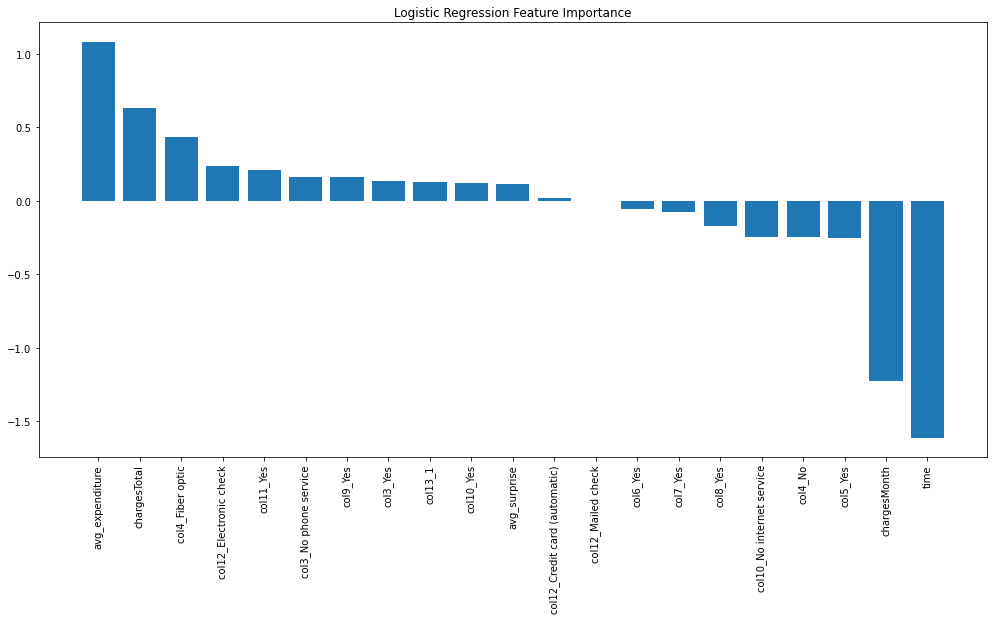

<Figure size 1080x720 with 0 Axes>

In [156]:
""" LR feature importance """
exclusion_list = []
exclusion_list = []  #, "chargesMonth", "chargesTotal", "time"]

# senza time charges total diventa proxy di time e quindi predice churn, 
# con time probablmente cattura il costo del servizio
# 2 fattori: prezzi maggiori portano ad andarsene, prezzi maggiori implicano più servizi
df = train_enh_pre_stded[[col for col in train_enh_stded.columns if col not in exclusion_list ]] 
X, y = create_X_y(df)

weights = {1:1, 2:4.25}

# get feature imporatnce over 10 fits
importances = []
for i in range(0,10):
        LR_stded = LogisticRegression(max_iter=2000,
                                random_state=i+10,
                                solver = 'liblinear',  
                                class_weight= weights) 
        LR_stded.fit(X, y)
        importances.append(LR_stded.coef_[0])

# get mean feature importance
num_arrays = len(importances)
arr_len = importances[0].shape[0]
importance = np.zeros(arr_len)
for arr in importances:
    importance += arr
importance = importance/num_arrays        

# preparations for plotting
#importance = LR_stded.coef_[0]
x =df.columns.drop("y")
y =importance
df = pd.DataFrame({_x:_y for _x,_y in zip(x,y)}, index=[0])
df = df.T.sort_values(df.index[-1], ascending=False).T
x = df.columns
y = df.values[0]

# plot
fig, ax = plt.subplots(figsize=(17, 8))
plt.title('Logistic Regression Feature Importance')
plt.figure(figsize=[15,10])
ax.bar(x,y,align='center')
canc = plt.setp(ax.get_xticklabels(), rotation = 90)

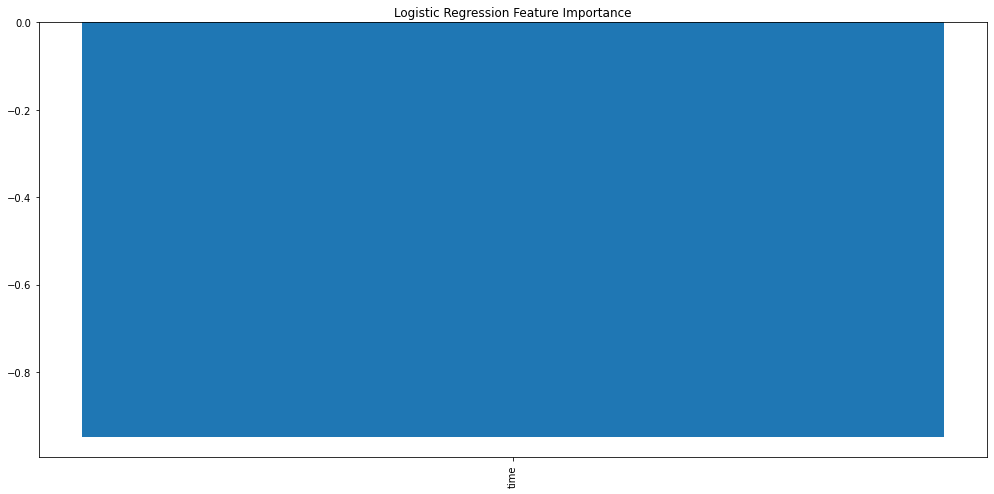

<Figure size 1080x720 with 0 Axes>

In [175]:
""" confirming sign interpretation """
exclusion_list = []
exclusion_list = [i for i in train_enh_pre_stded.columns if i not in ["y", "time"]]  #, "chargesMonth", "chargesTotal", "time"]

# senza time charges total diventa proxy di time e quindi predice churn, 
# con time probablmente cattura il costo del servizio
# 2 fattori: prezzi maggiori portano ad andarsene, prezzi maggiori implicano più servizi
df = train_enh_pre_stded[[col for col in train_enh_stded.columns if col not in exclusion_list ]] 
X, y = create_X_y(df)

weights = {1:1, 2:4.25}

# get feature imporatnce over 10 fits
importances = []
for i in range(0,10):
        LR_stded = LogisticRegression(max_iter=2000,
                                random_state=i+10,
                                solver = 'liblinear',  
                                class_weight= weights) 
        LR_stded.fit(X, y)
        importances.append(LR_stded.coef_[0])

# get mean feature importance
num_arrays = len(importances)
arr_len = importances[0].shape[0]
importance = np.zeros(arr_len)
for arr in importances:
    importance += arr
importance = importance/num_arrays        

# preparations for plotting
#importance = LR_stded.coef_[0]
x =df.columns.drop("y")
y =importance
df = pd.DataFrame({_x:_y for _x,_y in zip(x,y)}, index=[0])
df = df.T.sort_values(df.index[-1], ascending=False).T
x = df.columns
y = df.values[0]

# plot
fig, ax = plt.subplots(figsize=(17, 8))
plt.title('Logistic Regression Feature Importance')
plt.figure(figsize=[15,10])
ax.bar(x,y,align='center')
canc = plt.setp(ax.get_xticklabels(), rotation = 90)

In [154]:
LR_stded.predict_proba(df.drop("y",axis=1))

array([[0.6055444 , 0.3944556 ],
       [0.22525583, 0.77474417],
       [0.19328964, 0.80671036],
       ...,
       [0.35065438, 0.64934562],
       [0.57750367, 0.42249633],
       [0.65069602, 0.34930398]])

In [153]:
df = train_enh_pre_stded[[col for col in train_enh_stded.columns if col not in exclusion_list ]] 
X, y = create_X_y(df)
df.drop("y",axis=1)

,time
0,0.680309
1,-1.075011
2,-1.279118
3,-0.544333
4,-0.952547
...,...
3995,1.210987
3996,1.619201
3997,-0.421869
3998,0.557845


# Extra 


## Upsampling\downsampling trials
note: using ratio=0 means no oversampling is computed

In [ ]:
def custom_scorer(y_true, y_predict):
    """ Crea un custom scorer da passare al cv_scores di SkLearn """
    
    # sottrai, così da avere zero se la predizione è corretta, 1 se FN e -1 se FP
    score_arr = y_predict - y_true
    score_arr[score_arr==-1] = 5
    #print("errori da 5 su errori totali: ", round(len(score_arr[score_arr==5])/len(score_arr) ,2) )
    
    return np.sum(score_arr)  

In [187]:
def k_folds_upsampling(model, train_df, k=10, thr=0.5, ratio=0.5, k_neighbors=5):
    """ requires model.predict_proba, assumes l=2 with y={1,2} """
    
    X, y = create_X_y(train_df)
    kf = KFold(n_splits=k)
    
    cv_scores = []
    y_tr_y_pr = []
    y_probs   = []
    for train_index, test_index in kf.split(X):
            X_train, X_test = X[train_index], X[test_index]
            y_train, y_test = y[train_index], y[test_index]
            
            # smote upsampling
            if ratio> 0:                
                sm = imblearn.over_sampling.SMOTE(random_state=0, sampling_strategy=ratio,k_neighbors=k_neighbors)
                X_train, y_train = sm.fit_resample(X_train, y_train)    
            
            model.fit(X_train, y_train)
            proba = model.predict_proba(X_test)
            y_pred = np.array([1 if i[0]> thr else 2 for i in proba ])

            score = custom_scorer(y_test, y_pred)
            cv_scores.append(score)
            y_tr_y_pr.append([y_test, y_pred])
            y_probs.append(proba)
    
    cv_scores = np.array(cv_scores)
    print("mean = ", cv_scores.mean(), "std =", cv_scores.std())
    print("normalized_mean = ", cv_scores.mean()/len(y_test), "test obs in k-fold = ", len(y_test))
    return cv_scores, y_tr_y_pr, y_probs

mean =  252.57142857142858 std = 16.378183597676017
normalized_mean =  0.44233174881160875 test obs in k-fold =  571


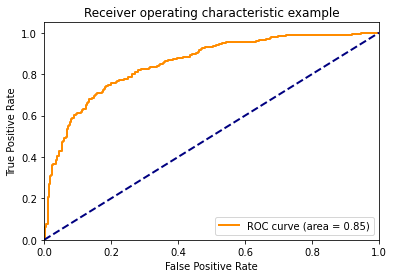

In [205]:
""" upsampling """
df = train_enh_stded #[[i for i in train_enh_dum.columns if i!="avg_surprise2"]]

weights = {1:1, 2:4.25}
LR = LogisticRegression(max_iter=2000,
                        #C = 0.7,
                        random_state=0,
                        solver = 'liblinear',  # liblinear good for small datasets
                        class_weight= weights) 

cv_result, _, _  = k_folds_upsampling(LR, df, 7, ratio=0.5, k_neighbors=800)

LR.fit(X, y)
fpr, tpr, roc_auc = find_ROC_Score(df, LR)
plot_ROC(fpr, tpr, roc_auc)

y_pred = LR.predict(df_test)
get_txt(y_pred, filename = "LR_Predictions.txt")

mean =  0.7206113833003231 std =  0.015154569568627653


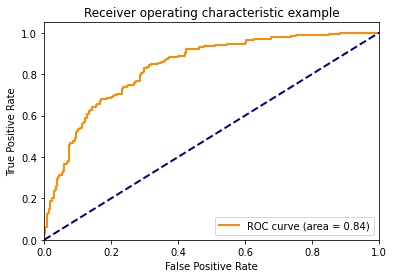

In [231]:
""" downsampling + upsampling """
df = train_enh_dum.copy(deep=True) #[[i for i in train_enh_dum.columns if i!="avg_surprise2"]]
df_test = test_enh_dum

# da 1500 in poi peggiora in remoto, da 800 e 1200 migliora
df = df.sort_values("y")
df = df.iloc[1130:,:]
X, y = create_X_y(df)

weights = {1:1, 2:4.25}
LR = LogisticRegression(max_iter=2000,
                        #C = 0.7,
                        random_state=100,
                        solver = 'liblinear',  # liblinear good for small datasets
                        class_weight= weights) 

cv_result = compute_cv(LR, X, y, 10, "balanced_accuracy")
#cv_result, _, _  = k_folds_upsampling(LR, df, 7, ratio=0.8, k_neighbors=800)

#ratio = 1
#k_neighbors = 30
#sm = imblearn.over_sampling.SMOTE(random_state=0, sampling_strategy=ratio,k_neighbors=k_neighbors)
#X, y = sm.fit_resample(X, y)    

LR.fit(X, y)
fpr, tpr, roc_auc = find_ROC_Score(df, LR)
plot_ROC(fpr, tpr, roc_auc)

y_pred = LR.predict(df_test)
get_txt(y_pred, filename = "LR_Predictions.txt")

In [207]:
""" confusion matrix """
df = train_enh_stded 
df = df.sort_values("y")
df = df.iloc[400:,:]

weights = {1:1, 2:4.25}
LR = LogisticRegression(max_iter=2000,
                        #C = 0.7,
                        random_state=0,
                        solver = 'liblinear',  # liblinear good for small datasets
                        class_weight= weights) 

cv_scores, y_tr_y_pr, _ = custom_k_folds(LR, df)

conf_matrices = np.zeros((2,2))
for i in range(len(y_tr_y_pr)):
    conf_matrix = confusion_matrix(y_tr_y_pr[i][0], y_tr_y_pr[i][1])
    conf_matrices += conf_matrix     
               
conf_matrices/len(y_tr_y_pr)

mean =  162.1 std = 21.84696775298577


array([[160.4,  93.6],
       [ 13.7,  92.3]])

mean =  -145.9 std =  21.97930845135943


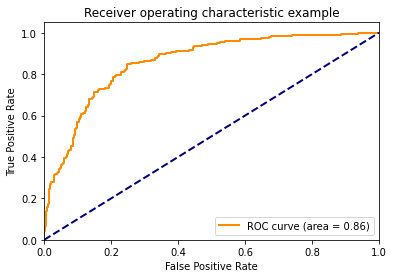

In [237]:
""" fit """

df = train_enh_dum
X, y = create_X_y(df)


prior_l = 0.35 
priors = [prior_l, 1-prior_l]

LDA = LinearDiscriminantAnalysis(solver = "eigen",
                                shrinkage="auto",
                                priors=priors) #priors=priors

cv_result = compute_cv(LDA, X, y, 10, scorer=loss_function)

LDA.fit(X,y)

fpr, tpr, roc_auc = find_ROC_Score(df, LDA)
plot_ROC(fpr, tpr, roc_auc)

y_pred = LDA.predict(df_test)
get_txt(y_pred, filename = "LDA_Predictions.txt")

## Feature Permutation

In [50]:
from sklearn.inspection import permutation_importance

X_train, X_test, y_train, y_test = tt_split(dset_enh_dum, test_size=0.18)

RF_class_weights  = {1:1, 2:5}
RF = RandomForestClassifier(n_estimators= 1000,
                            n_jobs=-1,
                            random_state=0,
                            class_weight= RF_class_weights,
                            max_leaf_nodes = 45,
                            criterion='entropy',
                            max_features="log2")

RF.fit(X_train,y_train)

result = permutation_importance(
    RF, X_test, y_test, n_repeats=10, random_state=42, n_jobs=2)

feature_names = [f'{dset_enh_dum.drop("y",axis=1).columns[i]}' for i in range(len(dset_enh_dum.columns)-1)]

forest_importances = pd.Series(result.importances_mean, index=feature_names)
feature_names

['time',
 'chargesMonth',
 'chargesTotal',
 'avg_surprise',
 'avg_surprise2',
 'avg_expenditure',
 'col3_No',
 'col3_No phone service',
 'col3_Yes',
 'col4_DSL',
 'col4_Fiber optic',
 'col4_No',
 'col5_No',
 'col5_No internet service',
 'col5_Yes',
 'col6_No',
 'col6_No internet service',
 'col6_Yes',
 'col7_No',
 'col7_No internet service',
 'col7_Yes',
 'col8_No',
 'col8_No internet service',
 'col8_Yes',
 'col9_No',
 'col9_No internet service',
 'col9_Yes',
 'col10_No',
 'col10_No internet service',
 'col10_Yes',
 'col11_No',
 'col11_Yes',
 'col12_Bank transfer (automatic)',
 'col12_Credit card (automatic)',
 'col12_Electronic check',
 'col12_Mailed check',
 'col13_0',
 'col13_1']

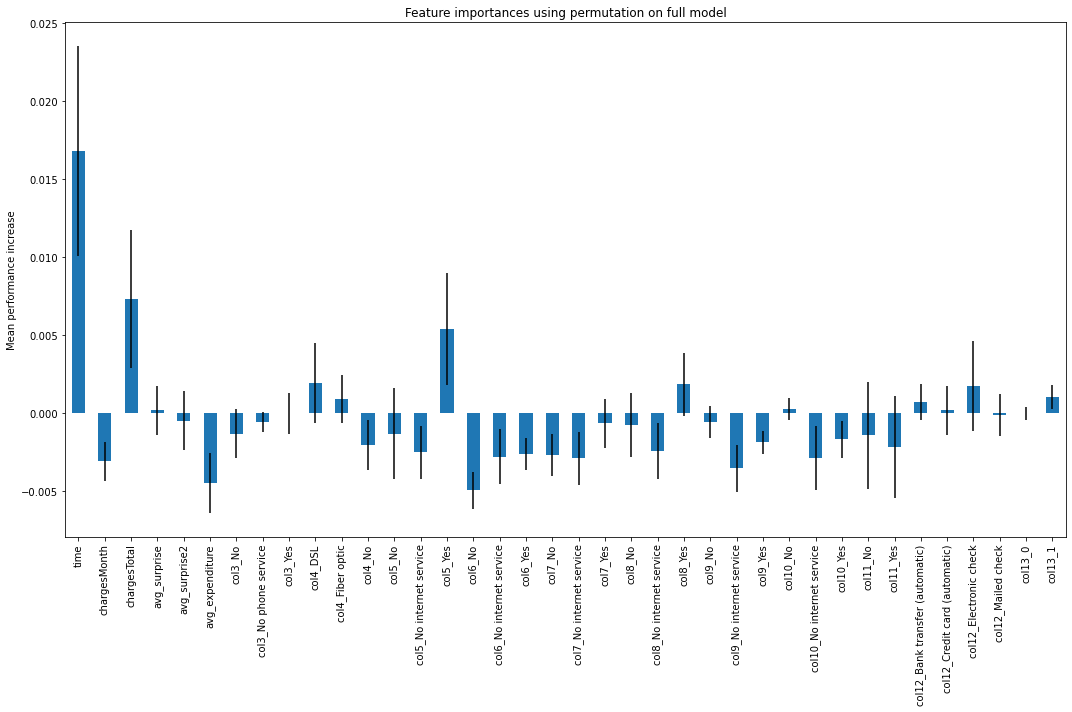

In [52]:
fig, ax = plt.subplots(figsize=(15, 10))
forest_importances.plot.bar(yerr=result.importances_std, ax=ax)
ax.set_title("Feature importances using permutation on full model")
ax.set_ylabel("Mean performance increase")
fig.tight_layout()
plt.show()